*Hint: Jupyter Notebooks feature autocompletion for modules and there functions - simply use the tab key for that in a code block*

# Import Python Modules
for `sqs_nqs_tools`:
`sqs_nqs_tools.offline` contains all (sub)-modules that are interesting for offline analysis
* `access` contains functions that use karabo data to enable easy access to hdf5 'raw' files (usually not directly used)
* `adata` contains functions to get some devices data (eg tof traces, motor position etc ...)
* `tof` contains functions for easy processing, analyzing and plotting of TOF data

In [1]:
%matplotlib notebook
import sqs_nqs_tools as nqs
from sqs_nqs_tools.offline import access, adata, tof

# Plot options
import matplotlib.pyplot as plt

# Import required libraries
import numpy as np 
import pyqtgraph as pg

# Import karabo libraries
import karabo_bridge as kb
import karabo_data as kd

Welcome to sqs_nqs_tools version v0.2+0.g4cd370f.dirty


# Basic functions for reading offline data
Define variable `raw_path` for path with run folders

In [2]:
raw_path ='/gpfs/exfel/exp/SQS/201802/p002195/scratch'
raw_path ='/gpfs/exfel/exp/SQS/201802/p002195/raw'

## Read TOF data

### Do it the hard and fundamental way
Define the paths that point to the TOF data - there a two paths `dirspec` pointing to the device and `elementspec` pointing to a specific part of the data stored for that device

*Note: this is to show you the functionality usually you will use the **easy and convenient way**.* You may want to skip the hard and fundamental way.

In [ ]:
dirspec='SQS_DIGITIZER_UTC1/ADC/1:network'
elementspec='digitizers.channel_1_A.raw.samples'

Now let's get the data

In [ ]:
tofdata = access.getData(raw_path + access.runFormat(100),dirspec,elementspec)

`tofdata` is an xarray DataArray. (see documentation http://xarray.pydata.org/en/stable/)

It has 2 dimensions [`shot`, `samples`]
* `shot` contains all shots for the whole run
* `samples` contains all samples from the digitizer - for our sample run there are 600'000 samples

It is a labeled array. The labels here are the `trainId`s. You can retrieve a list of trainIds from the array `tofdata.trainId`.

This labeling enables the selection of a shot not only by index, but also by trainId. Here we demonstrate this by selecting such trace and plotting it

In [ ]:
single_trace=tofdata.sel(trainId=108779907)
plt.plot(single_trace)
plt.show()

you can also plot a single trace by index and show the corresponding train id in the title:

In [ ]:
single_trace=tofdata[5,:]
plt.plot(single_trace)
plt.title("Train ID: "+str(int(single_trace.trainId)))
plt.show()

or you plot an average over all shots in the run - you may also select only the range of the TOF data you are interested in

In [ ]:
avg_trace=np.mean(tofdata,axis=0)
plt.plot(avg_trace)
plt.title("Average - Full range")
plt.show()

tof_range = range(250000,480000)
plt.plot(tof_range,avg_trace[tof_range])
plt.title("Average - Selected range")
plt.show()

You may want to integrate over certain ranges - we show this for the averaged traces:

In [ ]:
# make a list of ranges
ranges = list()
# make a list for the integrals
integrals = list()
# add ranges to that list of ranges
ranges.append(range(260000,280000))
ranges.append(range(300000,320000))
ranges.append(range(340000,360000))

#plot tof trace
plt.plot(tof_range,avg_trace[tof_range])
#plot ranges
for i in range(len(ranges)):
    plt.axvspan(min(ranges[i]),max(ranges[i]),alpha=0.1) #plt.axvspan(min x , max x , alpha=0.1 makes transpancy - 0 fully transparent, 1 not transparent)
plt.show() # give out the plot and show it in notebook

#do the integrals
for i in range(len(ranges)): # this is a for loop equal to for i = 0:len(ranges) in matlab
    integrals.append(np.sum(avg_trace[ranges[i]]))
#print the results
print("Integrals : " + str(np.asarray(np.round(integrals,2))))

### Do it the easy and convenient way

For the easy and convenient way we have already some default values in place. 

`adata.getTOF()` is the function to get the tof data. (remember: `adata` is used to access data in a convenient fashion)

It takes one required argument, that is the run number e.g. 100.

#### Default Values and Optional Arguments
`dirspec` and `elementspec` are provided, but in case they differ for your case you can call them as keywordarguments in `adata.getTOF`. 

The same goes for `path` here the `raw` directory for the current experiment (2195) is the default value - since we are using a run that we put in the scratch directory, the `path` to the directory containg the run folder(s) is specified as a keywordargument. 

Also the `tof range` may is to specifiy. Here the default value is likely not to be applicable to your situation.

In [3]:
[TOFtrace, TOFrange]  = adata.getTOF(80, tofrange=(142000,142000+400000))
TOFtrace=TOFtrace-1850

It is very simple now to make a simple plot (even with labeled axis) of a single trace selected by index:
(remember the `tof` module will provide helpful functions for plotting and processing)

<IPython.core.display.Javascript object>


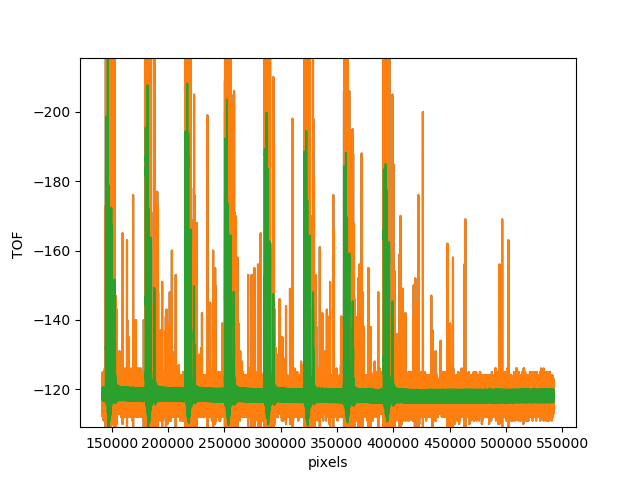

In [4]:
tof.plotTOF(TOFrange, TOFtrace[5,:])
plt.show()

Or by train id

In [6]:
tof.plotTOF(TOFrange, TOFtrace.sel(trainId=124345675))

We can also make an average

In [7]:
tof.plotTOF(TOFrange, tof.averageTOF(TOFtrace))

Plot the 100 brightest tof spectra for a run in a waterfall plot
keywordarguments
* `nbright` - number of brightest tof spectra to show
* `threshSum` - eg. if 0.1 a shot is only even considered when its overall integral is at least 10% of the maximum overall integral for the run
* `behlkeAt` - index at which behlke is switched on - everything before is excluded
* `integrateAt` - tofrange over which is integrated to determine the brightest shot

function returns an array with the train id for the xx brightest shots

In [ ]:
brightest_shots_ids = tof.waterfallBrightest_labelByTrainId(TOFrange, TOFtrace, nbright=10, 
                                      threshSum=0.1, behlkeAt=142000,
                                      integrateAt=(142000 , 542000))

In [ ]:
brightest_shots_ids

In [ ]:
tof.plotTOF(TOFrange, TOFtrace.sel(trainId=124346005))

In [ ]:
%matplotlib notebook

In [ ]:
plt.plot( TOFtrace.sel(trainId=124346005))
plt.show()

In [ ]:
TOFtrace.shape


# pnCCD

Let's take a look on how to read out the pnCCD data for offline analysis. So far (03.06.19) there is no recorded pnCCD data in SQS2195, which is why this Tutorial will use data from SQS2430.

Run 745 provides good sample data

**Since there is no part in the python module yet we will have to do it the hard way**

In [16]:
raw_path ='/gpfs/exfel/exp/SQS/201802/p002195/raw'
dirspec='SQS_NQS_PNCCD1MP/CAL/PNCCD_FMT-0:output' # this is the corrected data
#dirspec='SQS_NQS_PNCCD1MP/RAW/PNCCD_FMT-0:output' # this is the raw (uncorrected) data
elementspec='data.image'

You can also get a list of all available sources ("dirspec")

In [11]:
for i in np.arange(780,800):
    print(i)
    print(access.allAvailableDataSources( raw_path + access.runFormat(i) ))
    print("----")

780
frozenset({'SQS_NQS_CRSC/ACTRL/SLIT_Z_WIDTH', 'SQS_AQS_VAC/MOTOR/NEEDLE_F1_Y', 'SQS_AQS_VAC/MOTOR/NEEDLE_F1_Z', 'SQS_AQS_MOV/MOTOR/Y_UPSTR_LEFT', 'SA3_XTD10_XGM/XGM/DOOCS', 'SQS_NQS_CRSC/MOTOR/NOZZLE_Z', 'SQS_NQS_DVMIS/TSYS/BEHLKE-2_TRIGGER', 'SQS_NQS_TPAD/TSYS/CAM_TRIGGER', 'SQS_AQS_VAC/MOTOR/NEEDLE_F1_X', 'SQS_NQS_DVMIS/TSYS/BEHLKE-1_TRIGGER', 'SA3_XTD10_XGM/XGM/DOOCS:output', 'SQS_AQS_MOV/MOTOR/Z_UPSTR_RIGHT', 'SQS_NQS_VAC/GAUGE/DUMP', 'SQS_AQS_VAC/MOTOR/NEEDLE_F1P_Z', 'SQS_NQS_CRSC/GAUGE/STAGE_1', 'SQS_AQS_MOV/MOTOR/Z_UPSTR_LEFT', 'SQS_NQS_CRSC/GAUGE/STAGE_2', 'FUSION_CDG', 'SQS_AQS_MOV/MOTOR/Y_DOWNSTR', 'SQS_DIGITIZER_UTC1/ADC/1:network', 'SQS_NQS_CRSC/TSYS/PARKER_TRIGGER', 'SQS_AQS_MOV/MOTOR/Y_UPSTR_RIGHT', 'SQS_AQS_VAC/MOTOR/NEEDLE_F1P_Y', 'SQS_NQS_CRSC/GAUGE/STAGE_3', 'SQS_AQS_VAC/MOTOR/NEEDLE_F1P_X', 'P_GATT', 'SA3_XTD10_VAC/GAUGE/G30510C', 'SQS_NQS_CRSC/MOTOR/NOZZLE_Y', 'SQS_NQS_CRSC/ASENS/SLIT_Z_WIDTH', 'SQS_NQS_CRSC/MOTOR/NOZZLE_X', 'SQS_RR_UTC/TSYS/TIMESERVER', 'SQS_NQ

Exception: No HDF5 files found in /gpfs/exfel/exp/SQS/201921/p002430/raw/r0788

retrieve the data for the whole run

In [56]:
# you can choose one of the two:
# pnCCDdata = access.getData(raw_path + access.runFormat(745),dirspec,elementspec) # low level
pnCCDdata = adata.getPnCCD(460,path=raw_path) # high level using experiment defaults
pnCCDdata_dark = adata.getPnCCD(453,path=raw_path) 

The high level function `adata.getPnCCD(runnr)` supports also a roi (just get the roi for all shots), therefore set the optional argument `full=False` and may specify a roi with `roi = [[xmin,xmax],[ymin,ymax]]`, without a specified ROI the full image will be returned anyways

Shape of the data

In [50]:
dark_mean = np.squeeze(np.mean( pnCCDdata_dark,axis=0))

In [51]:
np.max(pnCCDdata.trainId)

<xarray.DataArray 'trainId' ()>
array(137170654, dtype=uint64)

plot a single shot by index

<IPython.core.display.Javascript object>


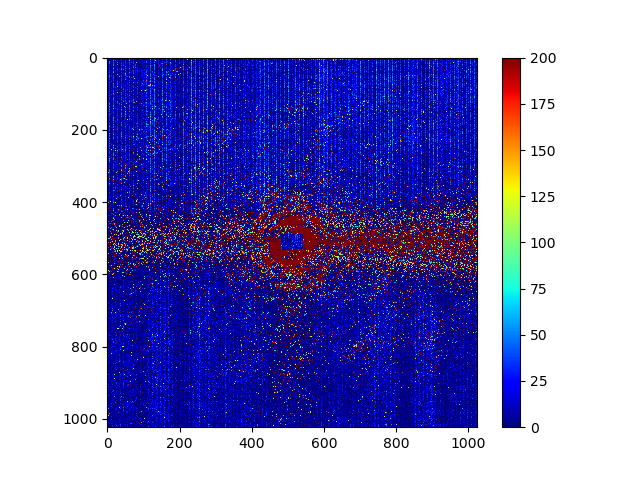

In [59]:
plt.figure()
plt.imshow((pnCCDdata.sel(trainId=137190421)-dark_mean),cmap='jet')
plt.colorbar()
plt.clim((0,200))
plt.show()

Train id of selected shot by index:

In [ ]:
pnCCDdata[100,:,:].trainId

plot a single shot by trainId (for sqs2430 run 745 this is the same shot as before)

In [ ]:
plt.figure()
plt.imshow(pnCCDdata.sel(trainId=128923736))
plt.colorbar()
plt.show()

plot averaged signal over all shots

<IPython.core.display.Javascript object>


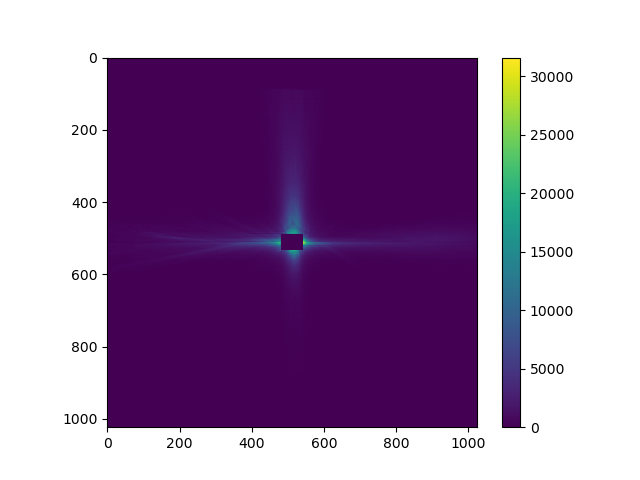

In [32]:
plt.figure()
plt.imshow(np.mean(pnCCDdata,axis=0)-dark_mean)
plt.colorbar()
plt.clim((0,None))
plt.show()

Integral over the averaged pnccd data:

In [47]:
np.sum(np.mean(pnCCDdata,axis=0))

<xarray.DataArray ()>
array(1.086888e+10)

In [48]:
pnCCDdata.trainId

<xarray.DataArray 'trainId' (trainId: 343)>
array([137170737, 137170738, 137170739, ..., 137171077, 137171078, 137171079],
      dtype=uint64)
Coordinates:
  * trainId  (trainId) uint64 137170737 137170738 ... 137171078 137171079

In [46]:
pnCCDdata.sel(trainId=137170620)

KeyError: 137170620

In [13]:
background_pnCCD = np.load('/home/bjoerns/code/XFEL_SQS_NQS_Tools/scripts/bokeh_live/background_pnCCD.npy')